# Problem Statement

**Title**: Developing an Emotion Recognition System for Real-Time Video Streams



**Description**:

This project aims to create a **deep learning model** capable of recognizing human emotions in real-time video streams. By processing live video data, the system will **detect and classify** facial expressions, contributing to applications in affective computing, human-computer interaction, and sentiment analysis. The project involves **data processing, model training, real-time inference** implementation, and performance evaluation, ultimately leading to a deployable emotion recognition system.


**Tasks:**

* **Data Loading**: Prepare and load the dataset for analysis.
* **Data OverSampling**: Address class imbalance by increasing samples in minority classes.
* **PCA & Outliers**: Reduce dimensionality with PCA and remove outliers for cleaner data.
* **DL Model Building**: Design the architecture for the deep learning model.
* **Training DL Model**: Train the model using the prepared data.
* **Evaluation & Metrics**: Assess model performance using various metrics.
* **Real Video Test**: Apply the model to real-world video data for evaluation.
* **LIVE Feed Video Test**: Test the model's performance on live video feeds for real-time analysis.

# About Dataset

The dataset chosen for this project is **FER2013**, which is a widely-used benchmark dataset for facial expression recognition. FER2013 consists of **48x48-pixel grayscale images** of human faces categorized into seven different emotions: anger, disgust, fear, happiness, sadness, surprise, and neutral. 

The dataset is split into two sets: training,and test sets, containing 28,709, and 7,178 images, respectively.


# Data Loading

In this section, I begin by reading the train and test images from their respective folders. Using appropriate functions, such as cv2.imread(), Once the images are loaded, I convert them into numpy arrays, along with their respective labels. 

Each image is associated with a label indicating the emotion it represents.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from scipy.spatial import distance

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, HTML, Video

from PIL import Image
import urllib.request


# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train_folder = '/kaggle/input/fer2013/train'
test_folder = '/kaggle/input/fer2013/test'

In [3]:
# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for emotion_folder in os.listdir(folder):
        label = emotion_folder
        for filename in os.listdir(os.path.join(folder, emotion_folder)):
            img = cv2.imread(os.path.join(folder, emotion_folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(label)
    return images, labels

In [4]:
# Load images and labels from train and test folders
train_images, train_labels = load_images_from_folder(train_folder)
test_images, test_labels = load_images_from_folder(test_folder)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Verify the shape of the datasets
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (28709, 48, 48)
Train labels shape: (28709,)
Test images shape: (7178, 48, 48)
Test labels shape: (7178,)


Afterward, to get a better understanding of the dataset, I sample some images from each class and display them as a grid. This visualization aids in inspecting the dataset's distribution and the nature of images present.

In [5]:
# Function to select sample images from each class
def select_sample_images(images, labels, num_samples=5):
    sample_images = []
    class_names = np.unique(labels)
    for class_name in class_names:
        class_indices = np.where(labels == class_name)[0][:num_samples]
        sample_images.extend(images[class_indices])
    return sample_images, class_names

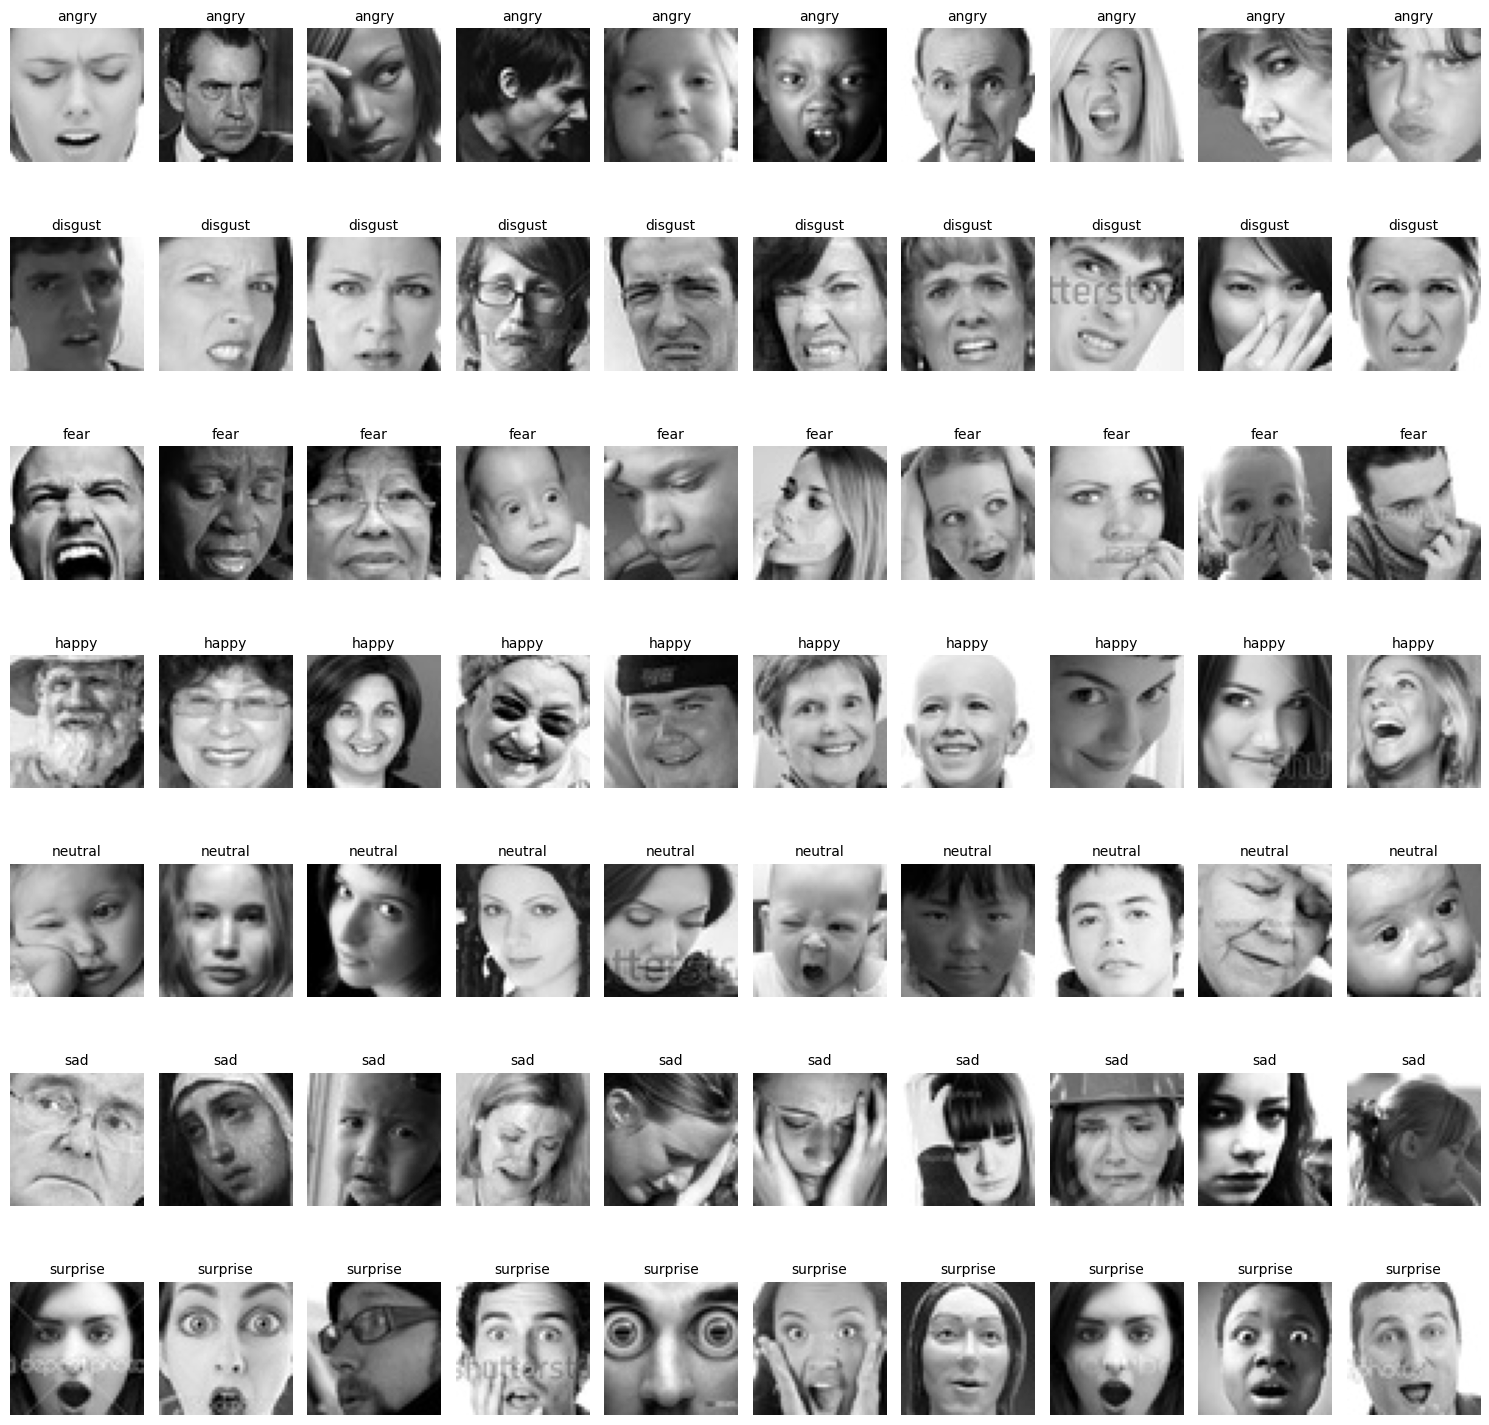

In [6]:
num_samples = 10

# Select sample images and class names
sample_images, class_names = select_sample_images(train_images, train_labels, num_samples)

# Plot sample images in a grid
num_classes = len(class_names)
fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 15))
for i, class_name in enumerate(class_names):
    class_indices = np.where(train_labels == class_name)[0][:num_samples]
    for j, idx in enumerate(class_indices):
        axes[i, j].imshow(train_images[idx], cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name, fontsize=10)

plt.tight_layout()
plt.show()

# Data OverSampling

In [7]:
# Calculate the count of images for each class in the training set
train_class_counts = {class_name: np.sum(train_labels == class_name) for class_name in np.unique(train_labels)}

# Create a bar chart using Plotly Express for training set only
fig = px.bar(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), color=list(train_class_counts.keys()))

# Customize the layout of the chart
fig.update_layout(
    title="Total samples for each class (Training set only)",
    xaxis_title="Emotion",
    yaxis_title="Count"
)
fig.update_traces(texttemplate='%{y}', textposition='inside')  # Display count labels on the bars

# Show the plot
fig.show()


it seems like the data is **imbalanced**. Some classes have significantly more samples than others. For example, classes like **happiness** have **7215** samples, while **disgust** has only **436** samples.

Imbalanced data can affect the **performance** of machine learning models, as they may become **biased** towards the majority class. Therefore, it's important to consider techniques such as **oversampling**.

Oversampling is like adding more synthetic images to dataset.

To address this Imbalanced data issue, I perform oversampling on the minority classes "**disgust**" and "**surprise**" using the Synthetic Minority Over-sampling Technique **(SMOTE)**. 

SMOTE generates synthetic samples for the minority class by **interpolating** between existing samples. This helps to balance the class distribution and improves the model's ability to learn from the minority classes.

Oversampling is a technique used to balance class distribution in imbalanced datasets by increasing the number of samples in minority classes through synthetic data generation or replication.


In a few lines, the process involves:

* Identifying the indices of the minority classes ("disgust" and "surprise").
* Resampling these classes using SMOTE to increase their sample count.
* Concatenating the original data with the resampled data to create a balanced dataset.
* Selecting a specific number of samples from the resampled data for certain classes to control the balance and size of the dataset.

In [8]:
from imblearn.over_sampling import SMOTE

# Identify the indices of "Disgust" and "Surprise" classes
disgust_indices = np.where(train_labels == "disgust")[0]
surprise_indices = np.where(train_labels == "surprise")[0]

# Combine the indices of both classes
indices_to_oversample = np.concatenate([disgust_indices, surprise_indices])

# Extract images and labels for the selected indices
X_to_oversample = train_images[indices_to_oversample]
y_to_oversample = train_labels[indices_to_oversample]

# Reshape the images to 2D (if needed)
X_to_oversample_2d = X_to_oversample.reshape(X_to_oversample.shape[0], -1)

# Define the oversampling strategy
oversample = SMOTE()

# Apply SMOTE to the selected classes
X_resampled, y_resampled = oversample.fit_resample(X_to_oversample_2d, y_to_oversample)

# Reshape the oversampled data back to its original shape
X_resampled = X_resampled.reshape(-1, *train_images.shape[1:])

# Check the new class distribution
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))

{'disgust': 3171, 'surprise': 3171}


Plotting **original** and **oversampled disgust** images allows visualizing the effect of oversampling on the class distribution. 

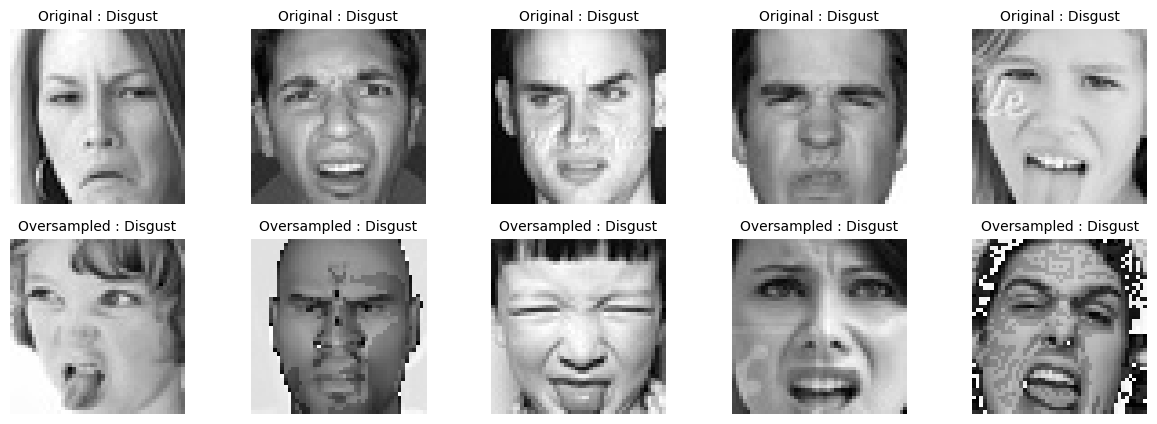

In [9]:
# Filter oversampled data for "disgust" class
disgust_resampled_indices = np.where(y_resampled == "disgust")[0]

# Choose random samples from the original "disgust" data
num_samples = 5
random_original_indices = np.random.choice(disgust_indices, num_samples, replace=False)

# Choose random samples from the oversampled data for "disgust" class
num_oversampled = min(num_samples, len(disgust_resampled_indices))
random_over_sample_indices = np.random.choice(disgust_resampled_indices, num_oversampled, replace=False)

# Plot original images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_original_indices):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(train_images[idx], cmap='gray')  # Original image
    plt.title("Original : Disgust", fontsize=10)
    plt.axis('off')

# Plot oversampled images
for i, idx in enumerate(random_over_sample_indices):
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(X_resampled[idx], cmap='gray')  # Oversampled image
    plt.title("Oversampled : Disgust", fontsize=10)
    plt.axis('off')

plt.show()


Plotting **original** and **oversampled** **surprise** images allows visualizing the effect of oversampling on the class distribution. 

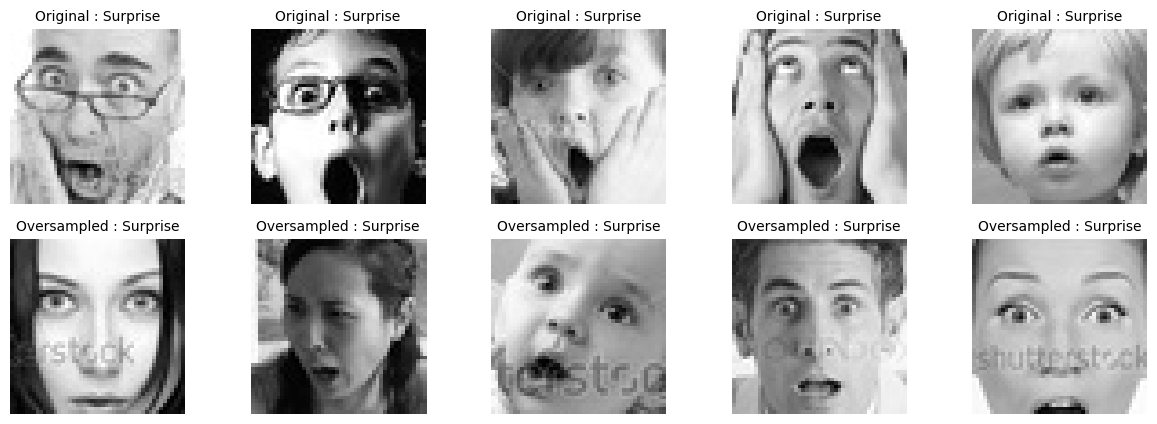

In [10]:
# Filter oversampled data for "disgust" class
surprise_resampled_indices = np.where(y_resampled == "surprise")[0]

# Choose random samples from the original "disgust" data
num_samples = 5
random_original_indices = np.random.choice(surprise_indices, num_samples, replace=False)

# Choose random samples from the oversampled data for "disgust" class
num_oversampled = min(num_samples, len(surprise_resampled_indices))
random_over_sample_indices = np.random.choice(surprise_resampled_indices, num_oversampled, replace=False)

# Plot original images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_original_indices):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(train_images[idx], cmap='gray')  # Original image
    plt.title("Original : Surprise", fontsize=10)
    plt.axis('off')

# Plot oversampled images
for i, idx in enumerate(random_over_sample_indices):
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(X_resampled[idx], cmap='gray')  # Oversampled image
    plt.title("Oversampled : Surprise", fontsize=10)
    plt.axis('off')

plt.show()


Selecting a specific **number of samples** from the resampled data for certain classes to control the balance and size of the dataset.

In [11]:
# Define the maximum number of samples for each class
max_surprise_samples = 500
max_disgust_samples = 2000

# Identify the indices of the "surprise" and "disgust" classes in the resampled data
surprise_indices = np.where(y_resampled == "surprise")[0]
disgust_indices = np.where(y_resampled == "disgust")[0]

# Select the first 500 samples for "surprise" and the first 1500 samples for "disgust"
selected_surprise_indices = surprise_indices[:max_surprise_samples]
selected_disgust_indices = disgust_indices[:max_disgust_samples]

# Concatenate the original train images with the selected oversampled images
final_train_images = np.concatenate([train_images, X_resampled[selected_surprise_indices], X_resampled[selected_disgust_indices]], axis=0)

# Create labels for the selected oversampled images
selected_surprise_labels = np.full(len(selected_surprise_indices), "surprise")
selected_disgust_labels = np.full(len(selected_disgust_indices), "disgust")

# Concatenate the original train labels with the selected oversampled labels
final_train_labels = np.concatenate([train_labels, selected_surprise_labels, selected_disgust_labels], axis=0)

final_train_images.shape, final_train_labels.shape

((31209, 48, 48), (31209,))

In [12]:
# Calculate the count of images for each class in the training set
train_class_counts = {class_name: np.sum(final_train_labels == class_name) for class_name in np.unique(final_train_labels)}

# Create a bar chart using Plotly Express for training set only
fig = px.bar(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), color=list(train_class_counts.keys()))

# Customize the layout of the chart
fig.update_layout(
    title="Total samples for each class after oversampling (Training set only)",
    xaxis_title="Emotion",
    yaxis_title="Count"
)
fig.update_traces(texttemplate='%{y}', textposition='inside')  # Display count labels on the bars

# Show the plot
fig.show()


In [13]:
final_train_images.shape, final_train_labels.shape

((31209, 48, 48), (31209,))

Now, The data looks **balanced**.




----------------------------------


# PCA & Outliers

In [14]:
# Reshape the image data to a 2D array
num_samples, height, width = final_train_images.shape

X_train_flattened = final_train_images.reshape(num_samples, height * width)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_flattened)
X_train_pca.shape

(31209, 2)

In [15]:
# Visualize the PCA-transformed data

hover_text = [f"Index: {index}" for index in range(len(X_train_pca))]

fig = px.scatter(x=X_train_pca[:, 0], y=X_train_pca[:, 1], color=final_train_labels, hover_name=hover_text, symbol=final_train_labels, title='PCA Visualization of Image Classes')
fig.update_traces(marker=dict(size=15))
fig.update_layout(xaxis_title='Principal Component 1', yaxis_title='Principal Component 2')
fig.update_layout(coloraxis_showscale=False)

fig.show()

I applied Principal Component Analysis (PCA) to visualize high-dimensional image data in a lower-dimensional space. 

PCA helped us identify outliers by comparing the original images with their reconstructed versions. By setting a threshold for the reconstruction error, images with significantly higher errors were flagged as outliers. 


total outliers =  (7,)


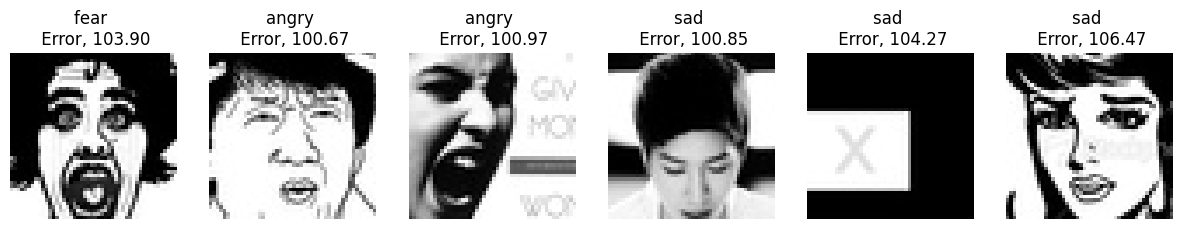

In [16]:
# Reconstruct images
X_reconstructed = pca.inverse_transform(X_train_pca)

# Calculate reconstruction error
reconstruction_errors = np.sqrt(np.mean(np.square(X_train_flattened - X_reconstructed), axis=1))

# Set threshold for outlier detection
threshold = 100  # Adjust as needed

# Find outliers
outlier_indices = np.where(reconstruction_errors > threshold)[0]

print("total outliers = ", outlier_indices.shape)

num_outliers_to_visualize = 6  # Choose the number of outliers to visualize

plt.figure(figsize=(15, 5))
for i, idx in enumerate(outlier_indices[:num_outliers_to_visualize]):
    plt.subplot(1, num_outliers_to_visualize, i + 1)
    plt.imshow(final_train_images[idx], cmap='gray')
    plt.title(f"{final_train_labels[idx]} \n Error, {reconstruction_errors[idx]:.2f}")
    plt.axis('off')

plt.show()


In [17]:
# Perform PCA with 3 compoinents

pca = PCA(n_components=3)
X_train_pca_3d = pca.fit_transform(X_train_flattened)

# Calculate the centroid of the main cluster
centroid = np.mean(X_train_pca_3d, axis=0)

# Calculate distances from the centroid
distances = distance.cdist([centroid], X_train_pca_3d, 'euclidean')[0]

# Define a threshold for outlier detection
threshold = np.percentile(distances, 99.5)  # Adjust the percentile as needed

# Identify outliers
outlier_indices = np.where(distances > threshold)[0]

# Define custom colors for outliers
outlier_color = 'rgb(0, 0, 0)'  # Black

# Define custom colors for each class
class_colors = {
    'angry': 'rgb(255, 0, 0)',  # Red
    'disgust': 'rgb(0, 255, 0)',  # Green
    'fear': 'rgb(0, 0, 255)',  # Blue
    'happy': 'rgb(255, 255, 0)',  # Yellow
    'neutral': 'rgb(255, 165, 0)',  # Orange
    'sad': 'rgb(128, 0, 128)',  # Purple
    'surprise': 'rgb(0, 128, 128)'  # Teal
}

# Create traces for each class
traces = []
for class_label, color in class_colors.items():
    indices = np.where(final_train_labels == class_label)[0]
    trace = go.Scatter3d(
        x=X_train_pca_3d[indices, 0],
        y=X_train_pca_3d[indices, 1],
        z=X_train_pca_3d[indices, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=color,
            opacity=0.8
        ),
        name=class_label
    )
    traces.append(trace)

# Create trace for outliers with hovertext including class names
outlier_hovertext = [f"Class: {_}" for _ in final_train_labels[outlier_indices]]
outlier_trace = go.Scatter3d(
    x=X_train_pca_3d[outlier_indices, 0],
    y=X_train_pca_3d[outlier_indices, 1],
    z=X_train_pca_3d[outlier_indices, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=outlier_color,
        opacity=0.8
    ),
    name='Outliers',
    hovertext=outlier_hovertext
)

traces.append(outlier_trace)

# Create layout with legend
layout = go.Layout(
    title='PCA Visualization of Image Classes with Outliers (3D)',
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    legend=dict(
        title='Classes',
        yanchor='top',
        y=0.99,
        xanchor='left',
        x=0.01
    )
)

# Create figure with traces and layout
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()


Outliers for angry = 27
Outliers for disgust = 11
Outliers for fear = 15
Outliers for happy = 30
Outliers for neutral = 21
Outliers for sad = 33
Outliers for surprise = 20


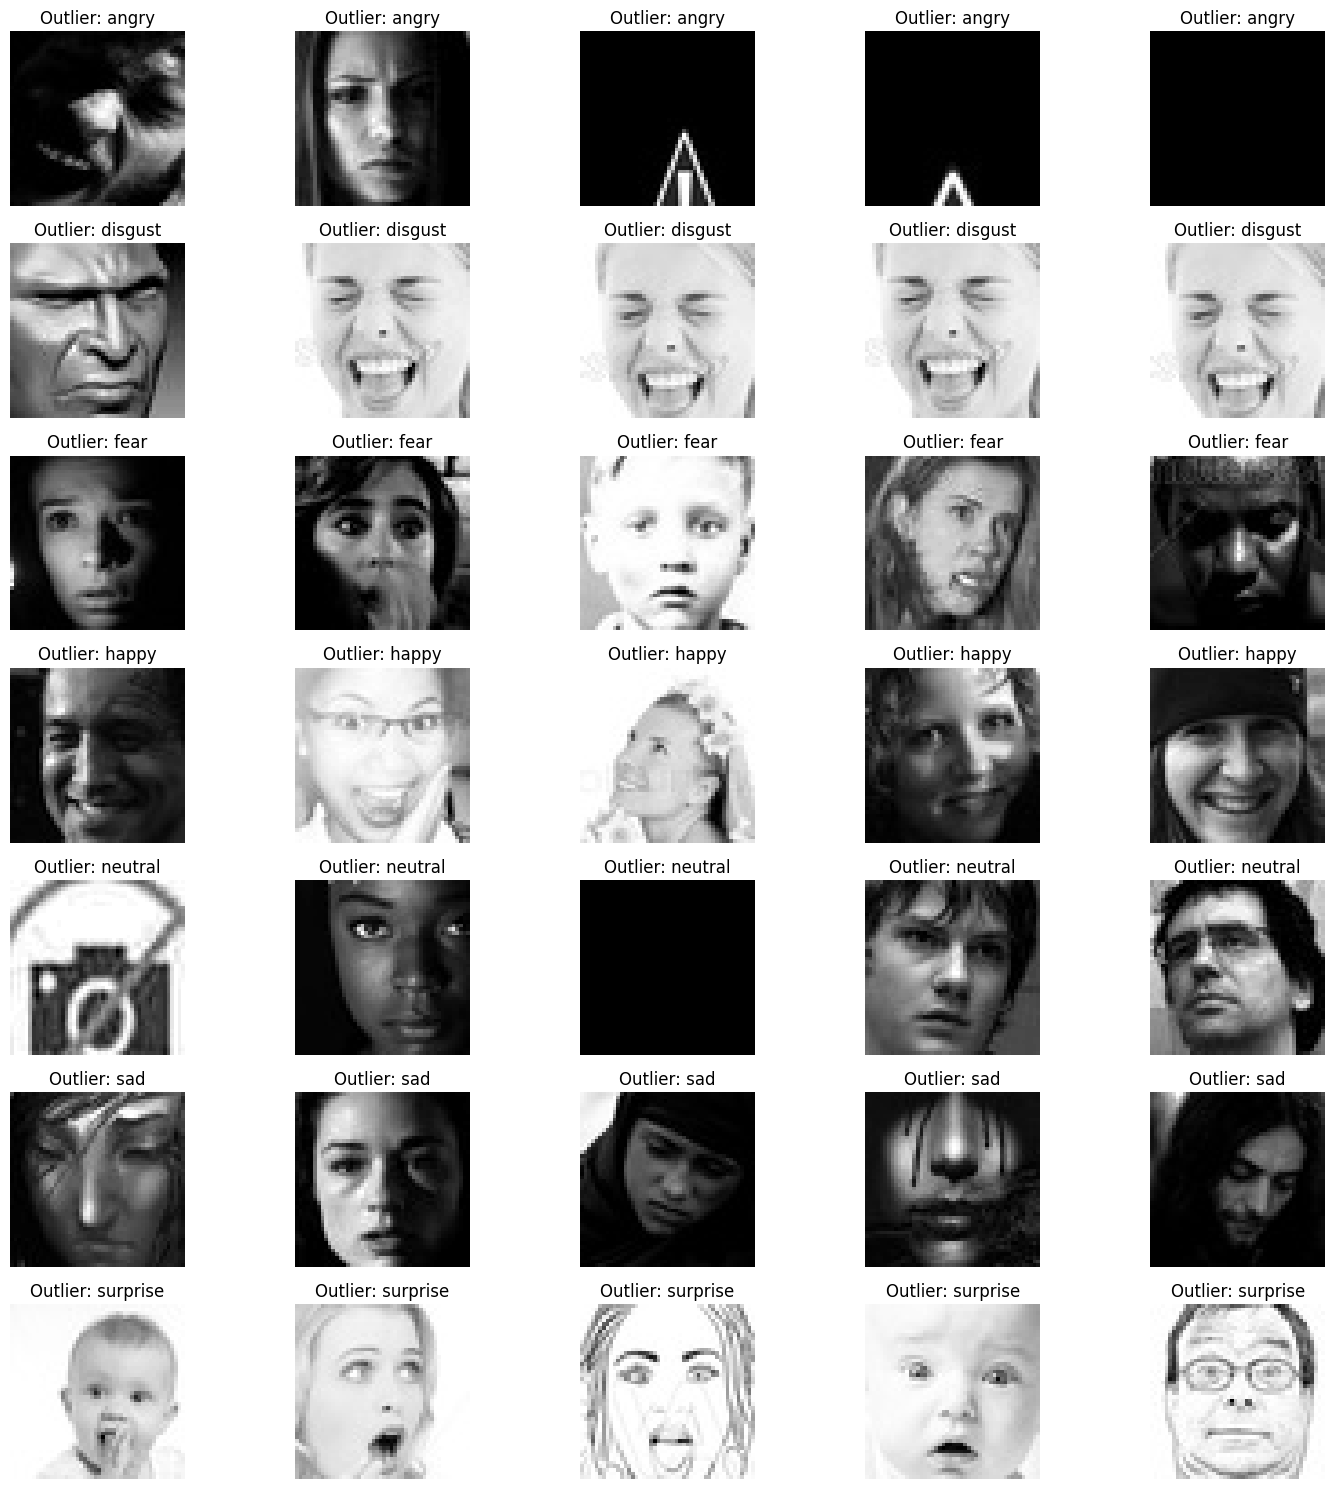

In [18]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
num_classes = len(class_names)
num_samples = 5 

fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 15))

for i, class_name in enumerate(class_names):
    class_indices = np.where(final_train_labels == class_name)[0]
    outlier_indices_for_class = np.intersect1d(class_indices, outlier_indices)  # Get outliers for current class
    num_outliers = len(outlier_indices_for_class)
    
    print("Outliers for {} = {}".format(class_name, num_outliers))
    
    # Select random outliers if there are more than num_samples
    if num_outliers > num_samples:
        outlier_indices_for_class = np.random.choice(outlier_indices_for_class, num_samples, replace=False)
    
    for j, outlier_idx in enumerate(outlier_indices_for_class):
        ax = axes[i, j]
        ax.imshow(final_train_images[outlier_idx], cmap='gray')
        ax.set_title(f'Outlier: {class_name}')
        ax.axis('off')

# Remove empty subplots
for i in range(num_classes):
    for j in range(num_samples, len(outlier_indices_for_class)):
        axes[i, j].remove()

plt.tight_layout()
plt.show()


In [19]:
# Remove outliers from final_train_images and final_train_labels
final_train_images_cleaned = np.delete(final_train_images, outlier_indices, axis=0)
final_train_labels_cleaned = np.delete(final_train_labels, outlier_indices, axis=0)

final_train_images.shape, final_train_images_cleaned.shape,

((31209, 48, 48), (31052, 48, 48))

----------------------------------


# DL Model Building

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [21]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 6 * 6, 512)  # Adjust this depending on input size
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 6 * 6)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
class CNN2(nn.Module):
    def __init__(self, num_classes):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.dropout3 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout3(x)
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

I designed couple of models CNN and CNN2 which has a series of layers 

1. **Input Layer**: The input images are grayscale images with a single channel.

2. **Convolutional Layers**: The model consists of several convolutional layers (`conv1`, `conv2`, `conv3`, `conv4`, `conv5`, `conv6`) followed by batch normalization layers (`bn1`, `bn2`, `bn3`) and rectified linear unit (ReLU) activation functions. These layers extract features from the input images by convolving learnable filters over the input image.

3. **Pooling Layers**: Max-pooling layers (`pool`) are used to reduce the spatial dimensions of the feature maps, which helps in reducing the computational complexity and controlling overfitting.

4. **Dropout Layers**: Dropout layers (`dropout1`, `dropout2`, `dropout3`) are added after some convolutional and pooling layers to randomly drop a fraction of the neuron units during training, which helps in regularizing the model and preventing overfitting.

5. **Fully Connected Layers**: The output of the convolutional layers is flattened and fed into fully connected layers (`fc1`, `fc2`) for classification. These layers perform the final classification based on the features extracted by the convolutional layers.

6. **Output Layer**: The output layer (`fc2`) produces the final output, which represents the predicted class probabilities. The number of units in this layer is equal to the number of classes in the classification task.

7. **Activation Function**: The output of the last fully connected layer is passed through a softmax activation function to obtain the predicted probabilities for each class.

In summary, this CNN2 architecture consists of alternating convolutional, pooling, and dropout layers followed by fully connected layers for classification, with batch normalization and ReLU activation functions used throughout the network to improve learning and performance.

In [23]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=1b957ea7a4351fa760f84946bbd574ab5be16c9444d4a23dc87d083ce9d69a2f
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [24]:
from torchviz import make_dot

In [25]:
#training data
X_train_tensor = torch.tensor(final_train_images_cleaned)
X_train_tensor = X_train_tensor.float()
X_train_tensor = torch.unsqueeze(X_train_tensor, 1)

print(X_train_tensor.shape, X_train_tensor.dtype)


#testing data
X_test_tensor = torch.tensor(test_images)
X_test_tensor = X_test_tensor.float()
X_test_tensor = torch.unsqueeze(X_test_tensor, 1)

print(X_test_tensor.shape, X_test_tensor.dtype)

torch.Size([31052, 1, 48, 48]) torch.float32
torch.Size([7178, 1, 48, 48]) torch.float32


This above code prepares the input data for training and testing:

* Converts the training and testing images into PyTorch tensors.
* Converts the tensors to float type.
* Adds an additional dimension to represent grayscale images.
* Prints the shape and data type of the tensors.

In [26]:
#training data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(final_train_labels_cleaned)
y_train_tensor = torch.tensor(y_train_encoded)

class_names = label_encoder.classes_
print(class_names)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#testing data
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(test_labels)
y_test_tensor = torch.tensor(y_test_encoded)

class_names = label_encoder.classes_
print(class_names)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


This above code segment prepares the label data for deep learning model training:

* It encodes class labels numerically.
* Converts data into PyTorch tensors.
* Creates datasets and data loaders for efficient training and testing.

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

-----------------------

# Training DL Model

* Instantiates a CNN model for classification.
* Specifies the number of output classes.
* Moves the model to the specified device (e.g., GPU).
* Defines CrossEntropyLoss as the loss function.
* Chooses Adam optimizer with a learning rate of 0.001.

In [31]:
# Instantiate the model
num_classes = 7
model = CNN2(num_classes)
model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Save model architecture as image
# dummy_input = torch.randn(1, 1, 48, 48)  # (batch_size, channels, height, width)
# dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))
# dot.render("model_visualization", format="png")

Training works like this


* It iterates over a specified number of epochs (num_epochs).
* Within each epoch, it sets the model to training mode and initializes the running loss.
* It iterates through batches of training data from the train_loader.
* For each batch, it moves the inputs and labels to the specified device (e.g., GPU), zeroes the optimizer gradients, performs a forward pass through the model to obtain predictions, calculates the loss using the specified criterion (CrossEntropyLoss), performs backward propagation to compute gradients, and updates the model parameters via optimization (Adam).
* It accumulates the running loss for each epoch.
* After each epoch, it prints the average loss.
* Finally, it saves the trained model's state dictionary to a file ('my_model.pth').

In [32]:
# Training loop
num_epochs = 700
final_loss = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
                
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels) 

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    final_loss.append(running_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')
        
    if epoch % 50 == 0:        
        model_name = "fer_model_"+ str(epoch)+ ".pth"
        torch.save(model.state_dict(), model_name)

# Save the final trained model
torch.save(model.state_dict(), 'fer_model_final.pth')

Epoch [1/700], Loss: 1.902821827745094
Epoch [2/700], Loss: 1.8682890304207924
Epoch [3/700], Loss: 1.7748467314501133
Epoch [4/700], Loss: 1.6863461236875164
Epoch [5/700], Loss: 1.6388276211387955
Epoch [6/700], Loss: 1.5958302902512398
Epoch [7/700], Loss: 1.5696027605467304
Epoch [8/700], Loss: 1.538970246005623
Epoch [9/700], Loss: 1.519031451364747
Epoch [10/700], Loss: 1.4963320230971158
Epoch [11/700], Loss: 1.4705462480917282
Epoch [12/700], Loss: 1.4559704024808906
Epoch [13/700], Loss: 1.4425402410735062
Epoch [14/700], Loss: 1.434926196426368
Epoch [15/700], Loss: 1.4183565175005386
Epoch [16/700], Loss: 1.4039774902939919
Epoch [17/700], Loss: 1.3986585330521164
Epoch [18/700], Loss: 1.3759123006515228
Epoch [19/700], Loss: 1.3573995276165303
Epoch [20/700], Loss: 1.3549979357346202
Epoch [21/700], Loss: 1.343741918997465
Epoch [22/700], Loss: 1.3281353801089875
Epoch [23/700], Loss: 1.318271493322449
Epoch [24/700], Loss: 1.3070538035995805
Epoch [25/700], Loss: 1.2950062

In [33]:
# Plotting the final loss
fig = go.Figure(data=go.Scatter(y=final_loss, mode='lines'))
fig.update_layout(title='Training Loss over Epochs',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

-----------------------------------------

# Evaluation & Metrics

The below code evaluates the trained model on the test dataset:

* It sets the model to evaluation mode.
* It iterates through batches of test data from the test_loader.
* For each batch, it moves the inputs and labels to the specified device (e.g., GPU).
* It performs a forward pass through the model to obtain predictions.
* It extracts predicted labels by selecting the index of the highest probability from the output.
* It appends true and predicted labels to separate lists.
* It counts the total number of samples processed.
* It counts the number of correct predictions by comparing predicted labels with true labels.


In [34]:
correct, total = 0, 0

true_labels, predicted_labels = [], []

# Evaluate the model
model.eval()

# Iterate over the dataset or batches
for inputs, labels in test_loader:
    # Forward pass
    
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = model(inputs)
    
    # Get predicted labels
    _, predicted = torch.max(outputs, 1)
    
    # Append true and predicted labels to lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

    # Count total number of samples
    total += labels.size(0)
    
    # Count number of correct predictions
    correct += (predicted == labels).sum().item()

This below code calculates the accuracy of the model's predictions on the test dataset:

* It divides the number of correct predictions (correct) by the total number of samples processed (total).
* It prints the accuracy as a percentage.
* Additionally, the code generates and plots the confusion matrix:
* 
* It uses the true labels (true_labels) and predicted labels (predicted_labels) to compute the confusion matrix using the confusion_matrix function from scikit-learn.
* It plots the confusion matrix as a heatmap using seaborn, with class names displayed on both axes.

Overall, this code provides insights into the model's performance by quantifying its accuracy and visualizing its predictive behavior through the confusion matrix.

Accuracy: 0.60


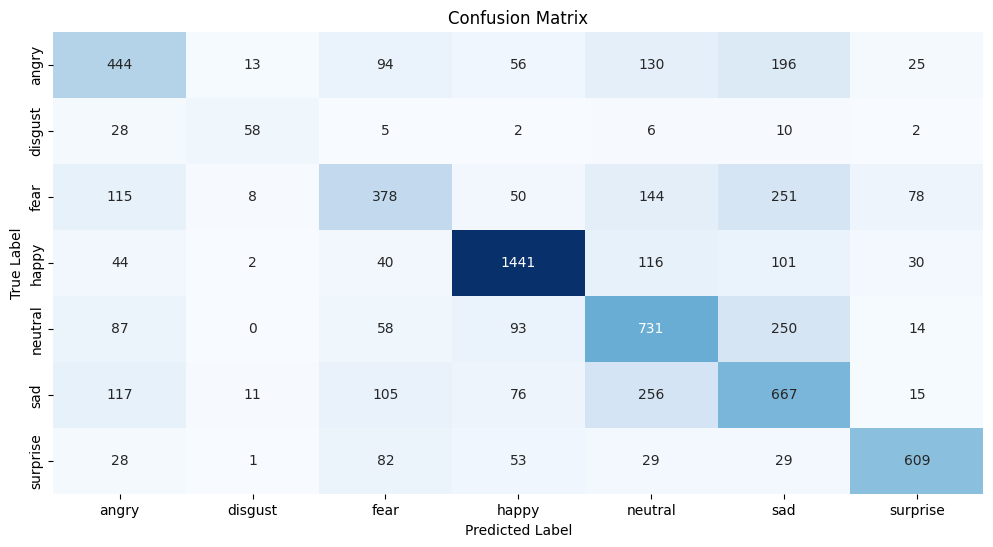

In [35]:
# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy:.2f}')

# Get the original class names
class_names = label_encoder.classes_

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with class names
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The below code generates a classification report and visualizes it as a heatmap:

* It uses the classification_report function from scikit-learn to compute various metrics (precision, recall, F1-score, and support) for each class.
* The target_names parameter specifies the class names to include in the report.
* It converts the classification report dictionary into a DataFrame using pandas for easier visualization.
* It plots the classification report DataFrame as a heatmap using seaborn, with metrics on the x-axis and classes on the y-axis.

Overall, this code provides a comprehensive summary of the model's performance across different classes, allowing for a quick and intuitive assessment of its classification performance.

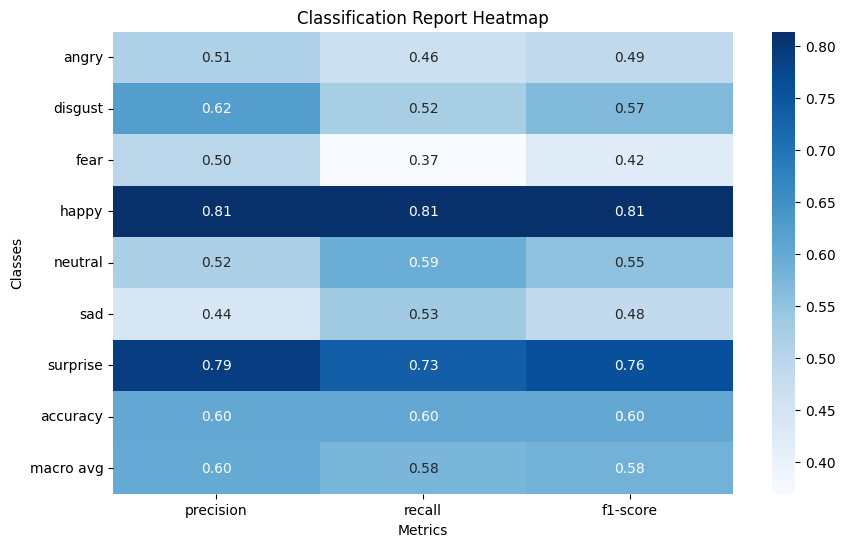

In [36]:
# Get classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

# Convert classification report to a DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()


-------------------------------------------------

# Real Video Test

In [37]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from scipy.spatial import distance

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, HTML, Video

from PIL import Image
import urllib.request

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)


In [38]:
class CNN2(nn.Module):
    def __init__(self, num_classes):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.dropout3 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout3(x)
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


The below code does:

* The XML file containing the Haar cascade classifier for detecting frontal faces is downloaded from a specified URL using urllib.
* The downloaded XML file is used to initialize the OpenCV CascadeClassifier object for face detection.
* The pre-trained CNN model, trained for a specified number of classes, is instantiated.
* The pre-trained weights of the model are loaded from the specified file path using torch.load(), ensuring that the model is loaded onto the CPU.
* The model is set to evaluation mode using eval().

In [39]:
# URL of the XML file
xml_url = 'https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml'

urllib.request.urlretrieve(xml_url, 'haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

#Loading the model after training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN2(7)
model.load_state_dict(torch.load('/kaggle/input/test/pytorch/60-percentage-accuracy/1/my_model60.pth', map_location=torch.device(device)))
model.to(device)
model.eval()

CNN2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_f

The below code does:

* Loads a sample video from a dictionary of URLs representing different emotions.
* Displays the video using IPython display, adjusting its width and height.
* Opens the video for processing using OpenCV's VideoCapture.
* Retrieves properties of the video: frame width, frame height, and frames per second (fps).
* Creates a VideoWriter object to write processed frames into an output video file ('/kaggle/working/out.mp4') with codec 'mp4v'.
* Prints the frame width, frame height, and frames per second of the input video.

In [40]:
some_sample_videos = {"happy": "https://degenden-academy.s3.ap-south-1.amazonaws.com/webapp_assets/projects/dl/1.mp4",
                     "angry": "https://degenden-academy.s3.ap-south-1.amazonaws.com/webapp_assets/projects/dl/2.mp4",
                     "fear": "https://degenden-academy.s3.ap-south-1.amazonaws.com/webapp_assets/projects/dl/3.mp4",
                     "surprise": "https://degenden-academy.s3.ap-south-1.amazonaws.com/webapp_assets/projects/dl/4.mp4",
                     "sad": "https://degenden-academy.s3.ap-south-1.amazonaws.com/webapp_assets/projects/dl/5.mp4",
                     "neutral": "https://degenden-academy.s3.ap-south-1.amazonaws.com/webapp_assets/projects/dl/6.mp4",
                     "disgust": "https://degenden-academy.s3.ap-south-1.amazonaws.com/webapp_assets/projects/dl/7.mp4"}

video_path = some_sample_videos['happy']
display(Video(video_path, width= 500, height=300))

# Open input video
output_video_path = '/kaggle/working/out.mp4'

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

print(frame_width, frame_height, fps)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

3840 2160 25


The below code processes each frame of the input video for face detection and emotion recognition:

- It iterates through each frame of the input video captured by the video capture object (cap).
- For each frame, it first converts the frame to grayscale for better face detection using the OpenCV cvtColor function.
- It then utilizes the face cascade classifier (face_cascade) to detect faces in the grayscale frame.
- Detected faces are cropped from the frame and preprocessed for emotion recognition:
  - Each face region is converted to a PIL image and resized to 48x48 pixels.
  - The resized image is converted to grayscale.
  - The grayscale image is converted to a NumPy array and transformed into a PyTorch tensor.
- The face image tensor is passed through the pre-trained CNN model to predict the emotion label.
- Predicted emotion labels are used to annotate the frame with bounding boxes around detected faces and corresponding emotion labels using OpenCV's rectangle and putText functions.
- The annotated frames are written to an output video file (out) using the VideoWriter object.
- Once all frames are processed, the video capture object and the video writer object are released.
- Finally, a message indicating the completion of video processing is printed.

In [41]:
# Process each frame of the input video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Process each detected face
    for (x, y, w, h) in faces:
        # Crop face region
        face_img = frame[y:y+h, x:x+w]

        # Convert face_img to PIL image
        face_img_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
        face_img_resized = face_img_pil.resize((48, 48))
        face_img_gray = face_img_resized.convert('L')
        
        # Convert PIL image to NumPy array
        face_img_np = np.array(face_img_gray)        
        face_img_tensor = torch.tensor(face_img_np, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
        
        # Send face image tensor to the model
        with torch.no_grad():
            outputs = model(face_img_tensor)
            
        # Get predicted emotion label
        _, predicted = torch.max(outputs, 1)
        predicted_label = class_names[predicted.item()]
                
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Draw the main text in orange
        cv2.putText(frame, predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 165, 255), 2)

        # Draw slightly offset text to create a bold effect in orange
        cv2.putText(frame, predicted_label, (x + 1, y - 9), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 165, 255), 2)
        cv2.putText(frame, predicted_label, (x + 2, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 165, 255), 2)

    out.write(frame)
    
    
# Release everything if job is finished
cap.release()
out.release()

print("Video is Done")

Video is Done


------------------------

# LIVE Feed Video Test

The below code works only on local machine, not on kaggle environment here.

In [42]:
import urllib.request
import cv2

from PIL import Image

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [43]:
class CNN2(nn.Module):
    def __init__(self, num_classes):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.dropout3 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout3(x)
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
def process_live_video(faceCascade):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = CNN2(7)
    model.load_state_dict(torch.load('/kaggle/input/test/pytorch/60-percentage-accuracy/1/my_model60.pth', map_location=torch.device(device)))

    print("Model has been loaded")

    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Failed to open camera.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture frame.")
            break

        # Convert frame to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(30, 30))

        for (x, y, w, h) in faces:

            # Crop face region
            face_img = frame[y:y+h, x:x+w]

            # Convert face_img to PIL image
            face_img_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
            face_img_resized = face_img_pil.resize((48, 48))
            face_img_gray = face_img_resized.convert('L')


            # Convert PIL image to NumPy array
            face_img_np = np.array(face_img_gray)        
            face_img_tensor = torch.tensor(face_img_np, dtype=torch.float).unsqueeze(0).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

            # Send face image tensor to the model
            with torch.no_grad():
                outputs = model(face_img_tensor)
                
            # Get predicted emotion label
            _, predicted = torch.max(outputs, 1)
            predicted_label = class_names[predicted.item()]

            # Draw rectangle around detected face and display predicted emotion label
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            
            # Draw the main text in orange
            cv2.putText(frame, predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 165, 255), 2)

            # Draw slightly offset text to create a bold effect in orange
            cv2.putText(frame, predicted_label, (x + 1, y - 9), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 165, 255), 2)
            cv2.putText(frame, predicted_label, (x + 2, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 165, 255), 2)

        
        print(frame.shape)
        
        cv2.imshow('FRAME',frame)


        key = cv2.waitKey(20)
        if key == 27: # exit on ESC
            break

    vc.release()
    cv2.destroyAllWindows()

In [45]:
xml_url = 'https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml'
urllib.request.urlretrieve(xml_url, 'haarcascade_frontalface_default.xml')

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
process_live_video(face_cascade)

Model has been loaded
Error: Failed to open camera.


[ WARN:0@8150.037] global cap_v4l.cpp:997 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@8150.038] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range
